<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/%D0%93%D0%B5%D0%B9%D0%BC%D1%81-%D0%A5%D0%B0%D1%83%D1%8D%D0%BB%D0%BB%20%D0%B4%D0%BB%D1%8F%20%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D1%83%D0%BD%D0%B8%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D0%BC%D0%BE%D1%80%D1%84%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.2 MB/s eta 0:00:00


In [2]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=53994591246690e777afa0e07bb5f7a47dc02218a3d77c6f3199e4928aba58c7
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [17]:
import os
import glob
import re
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
import pymorphy2

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Изменение имени файла
dictionary_file = "cleaned_tihonov (5).txt"

# Инициализация pymorphy
morph = pymorphy2.MorphAnalyzer()

# Считываем словарь морфем
morpheme_dictionary = {}
with open(dictionary_file, 'r', encoding='utf-8') as dict_file:
    for line in dict_file:
        line = line.strip()
        if line:
            word, morphemes = line.split()  # Используем split без аргументов для автоматического разделения по пробелам или табуляции
            morpheme_count = morphemes.count('/') + morphemes.count('(') + 1  # Считаем и символы '/' и '('
            morpheme_dictionary[word.lower()] = morpheme_count

# Список для хранения данных
data = []

# Список для хранения уникальных лемм в каждом файле
unique_lemmas_per_file = []

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    avg_morpheme_counts = []

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            tokens = re.findall(r'\b\w+\b', text)

            unique_lemmas = set()  # Инициализируем множество для хранения уникальных лемм в текущем файле

            # Находим уникальные леммы в текущем файле
            for token in tokens:
                lemma = morph.parse(token)[0].normal_form
                if re.match(r'^[а-яА-Я]+$', lemma):  # Проверяем, является ли лемма кириллической
                    unique_lemmas.add(lemma)

            unique_lemmas_per_file.append(unique_lemmas)  # Добавляем множество уникальных лемм в список

            # Создаем множество всех уникальных лемм из всех файлов
            all_unique_lemmas = set().union(*unique_lemmas_per_file)

            # Находим уникальные леммы, не совпадающие со словарем морфем
            non_matching_lemmas_unique = len(all_unique_lemmas - set(morpheme_dictionary.keys()))

            # Обработка каждого файла для подсчета количества морфем у уникальных лемм
            total_morpheme_count = 0
            for lemma in unique_lemmas:
                if lemma in morpheme_dictionary:
                    morpheme_count = morpheme_dictionary[lemma]
                    total_morpheme_count += morpheme_count

            # Среднее количество морфем для файла
            avg_morpheme_count = total_morpheme_count / len(unique_lemmas) if unique_lemmas else 0
            avg_morpheme_counts.append(avg_morpheme_count)

            # Добавляем данные в список для анализа
            data.append((cefr_level, avg_morpheme_count))

    # Добавляем средние значения в общий список
    avg_morpheme_counts_all.extend(avg_morpheme_counts)

# Вычисляем статистики для количества морфем во всех файлах
mean_morpheme_count_all = np.mean(avg_morpheme_counts_all)
sd_morpheme_count_all = np.std(avg_morpheme_counts_all)
std_error_morpheme_count_all = stats.sem(avg_morpheme_counts_all)
ci_morpheme_count_all = stats.t.interval(0.95, len(avg_morpheme_counts_all) - 1, loc=mean_morpheme_count_all, scale=std_error_morpheme_count_all)

# Выводим статистики для количества морфем во всех файлах
print("Статистики для количества морфем во всех файлах:")
print(f"Mean: {mean_morpheme_count_all}")
print(f"SD: {sd_morpheme_count_all}")
print(f"Std. Error: {std_error_morpheme_count_all}")
print(f"95% CI (confidence interval) (mean): {ci_morpheme_count_all}")

# Выводим количество лемм, не совпадающих со словарем морфем
print(f"Количество лемм, не совпадающих со словарем морфем: {non_matching_lemmas_unique}")

# Создаем DataFrame
df = pd.DataFrame(data, columns=['CEFR Level', 'Avg Morpheme Count'])

# ANOVA
anova_result = pg.anova(data=df, dv='Avg Morpheme Count', between='CEFR Level')

# Тест Геймса-Хауэлла
games_howell_result = pg.pairwise_gameshowell(data=df, dv='Avg Morpheme Count', between='CEFR Level')

# Вывод результатов
print(f"F-статистика (ANOVA): {anova_result['F'][0]}")
print(f"p-value (ANOVA): {anova_result['p-unc'][0]}")

print("\nGames-Howell Test Results:")
print(games_howell_result)

Статистики для количества морфем во всех файлах:
Mean: 2.236688458670682
SD: 0.13242433547058843
Std. Error: 1.1430947220059942e-05
95% CI (confidence interval) (mean): (2.236666054425619, 2.2367108629157446)
Количество лемм, не совпадающих со словарем морфем: 2278
F-статистика (ANOVA): 166.23167123723076
p-value (ANOVA): 9.118209353197132e-89

Games-Howell Test Results:
    A   B   mean(A)   mean(B)      diff        se          T          df  \
0  A1  A2  1.788852  1.978918 -0.190066  0.040389  -4.705880   67.541553   
1  A1  B1  1.788852  2.127423 -0.338571  0.040041  -8.455687   65.252897   
2  A1  B2  1.788852  2.240244 -0.451392  0.041116 -10.978615   72.315759   
3  A2  B1  1.978918  2.127423 -0.148505  0.010445 -14.217170  834.226292   
4  A2  B2  1.978918  2.240244 -0.261326  0.014012 -18.649753  274.697171   
5  B1  B2  2.127423  2.240244 -0.112821  0.012974  -8.696019  212.870315   

           pval    hedges  
0  7.534428e-05 -0.966799  
1  2.638956e-11 -2.009505  
2  0.0000

In [18]:
import os
import glob
import re
import pymorphy2

# Изменение имени файла
dictionary_file = "cleaned_tihonov (5).txt"

# Инициализация pymorphy
morph = pymorphy2.MorphAnalyzer()

# Считываем словарь морфем
morpheme_dictionary = {}
with open(dictionary_file, 'r', encoding='utf-8') as dict_file:
    for line in dict_file:
        line = line.strip()
        if line:
            word, morphemes = line.split()  # Используем split без аргументов для автоматического разделения по пробелам или табуляции
            morpheme_count = morphemes.count('/') + morphemes.count('(') + 1  # Считаем и символы '/' и '('
            morpheme_dictionary[word.lower()] = morpheme_count

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Создаем множество для хранения уникальных лемм, совпадающих со словарем морфем
matching_lemmas_set = set()

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            tokens = re.findall(r'\b\w+\b', text)

            # Вычисляем уникальные леммы, совпадающие со словарем морфем
            matching_lemmas_in_file = {morph.parse(token)[0].normal_form for token in tokens if morph.parse(token)[0].normal_form in morpheme_dictionary}

            # Добавляем уникальные леммы в множество
            matching_lemmas_set.update(matching_lemmas_in_file)

# Количество уникальных лемм, совпадающих со словарем морфем
matching_lemmas_count = len(matching_lemmas_set)

# Выводим количество лемм, совпадающих со словарем морфем
print(f"Количество уникальных лемм, совпадающих со словарем морфем: {matching_lemmas_count}")

Количество уникальных лемм, совпадающих со словарем морфем: 5184


In [19]:
import os
import glob
import re
import pandas as pd
import pymorphy2

# Инициализация pymorphy
morph = pymorphy2.MorphAnalyzer()

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Список для хранения уникальных несовпадающих лемм по каждому уровню CEFR
unique_non_matching_lemmas_per_cefr_level = []

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    # Список для хранения уникальных несовпадающих лемм по текущему уровню CEFR
    unique_non_matching_lemmas = set()

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            tokens = re.findall(r'\b\w+\b', text)

            # Находим уникальные леммы, не совпадающие со словарем морфем, в текущем файле
            non_matching_lemmas = {morph.parse(token)[0].normal_form for token in tokens if morph.parse(token)[0].normal_form not in morpheme_dictionary}

            # Добавляем уникальные леммы в список для текущего уровня CEFR
            unique_non_matching_lemmas.update(non_matching_lemmas)

    # Добавляем список уникальных несовпадающих лемм в список для всех уровней CEFR
    unique_non_matching_lemmas_per_cefr_level.append(unique_non_matching_lemmas)

# Вычисление общего количества уникальных несовпадающих лемм для всех уровней CEFR
total_unique_non_matching_lemmas = set().union(*unique_non_matching_lemmas_per_cefr_level)

# Вычисление процента уникальных несовпадающих лемм относительно всех токенов для всех уровней CEFR
total_tokens = sum(len(re.findall(r'\b\w+\b', open(file_path, 'r', encoding='utf-8').read())) for file_path in glob.glob("/content/Students_texts/*/*.txt"))
non_matching_tokens = sum(len(tokens) for tokens in unique_non_matching_lemmas_per_cefr_level)
non_matching_percentage = (non_matching_tokens / total_tokens) * 100 if total_tokens > 0 else 0

# Запись результатов в файл
with open("statistics.txt", "w", encoding="utf-8") as stat_file:
    stat_file.write("Уникальные несовпадающие леммы:\n")
    for lemma in total_unique_non_matching_lemmas:
        stat_file.write(lemma + "\n")
    stat_file.write(f"\nПроцент уникальных несовпадающих лемм относительно всех токенов: {non_matching_percentage:.2f}%\n")

print("Статистика сохранена в файле 'statistics.txt'.")

Статистика сохранена в файле 'statistics.txt'.


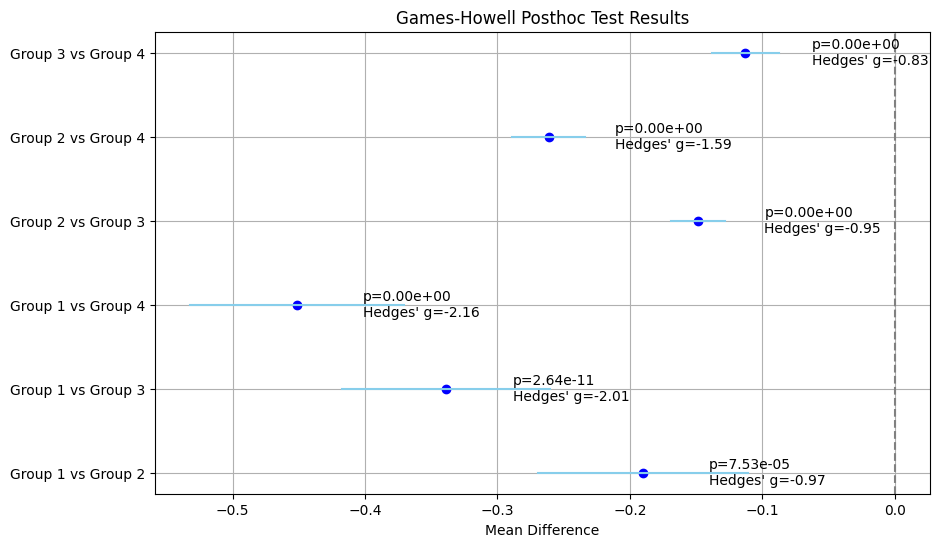

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Результаты теста Геймса-Хауэла
games_howell_result = pd.DataFrame({
    'A': ['Group 1', 'Group 1', 'Group 1', 'Group 2', 'Group 2', 'Group 3'],
    'B': ['Group 2', 'Group 3', 'Group 4', 'Group 3', 'Group 4', 'Group 4'],
    'mean(A)': [1.788852, 1.788852, 1.788852, 1.978918, 1.978918, 2.127423],
    'mean(B)': [1.978918, 2.127423, 2.240244, 2.127423, 2.240244, 2.240244],
    'diff': [-0.190066, -0.338571, -0.451392, -0.148505, -0.261326, -0.112821],
    'se': [0.040389, 0.040041, 0.041116, 0.010445, 0.014012, 0.012974],
    'T': [-4.705880, -8.455687, -10.978615, -14.217170, -18.649753, -8.696019],
    'df': [67.541553, 65.252897, 72.315759, 834.226292, 274.697171, 212.870315],
    'pval': [7.534428e-05, 2.638956e-11, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
    'hedges': [-0.966799, -2.009505, -2.159490, -0.951199, -1.589954, -0.830153]
})

# Расчет доверительных интервалов
z_score = 1.96
conf_intervals = [
    (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result['diff'], games_howell_result['se'])
]

# Построение графика
plt.figure(figsize=(10, 6))
for i, (group, ci, p, h) in enumerate(
    zip(games_howell_result['A'] + ' vs ' + games_howell_result['B'], conf_intervals, games_howell_result['pval'], games_howell_result['hedges'])
):
    plt.plot(ci, [i, i], color="skyblue")
    plt.scatter(games_howell_result['diff'].iloc[i], i, color="blue")
    plt.text(games_howell_result['diff'].iloc[i] + 0.05, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center')

# Элементы оформления
plt.yticks(range(len(games_howell_result)), games_howell_result['A'] + ' vs ' + games_howell_result['B'])
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Mean Difference")
plt.title("Games-Howell Posthoc Test Results")
plt.grid(True)
plt.show()